In [4]:
from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import tensorflow as tf
from tensorflow import keras
import os

import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import random
from tensorflow.keras.preprocessing.image import load_img

In [5]:
IMAGE_SIZE = [224, 224]
weight_size = 224
height_size = 224
batch_size = 32

In [6]:
train_path = './dataset/train/'
valid_path = './dataset/valid/'
test_path = './dataset/test/'

### Data Exploration

In [4]:
# Get a list of classes (groups) in your dataset
classes = [class_name for class_name in sorted(os.listdir(train_path)) if not class_name.startswith('.')]
print("Classes:", classes)

Classes: ['kick', 'kicknt', 'punch', 'punchnt']


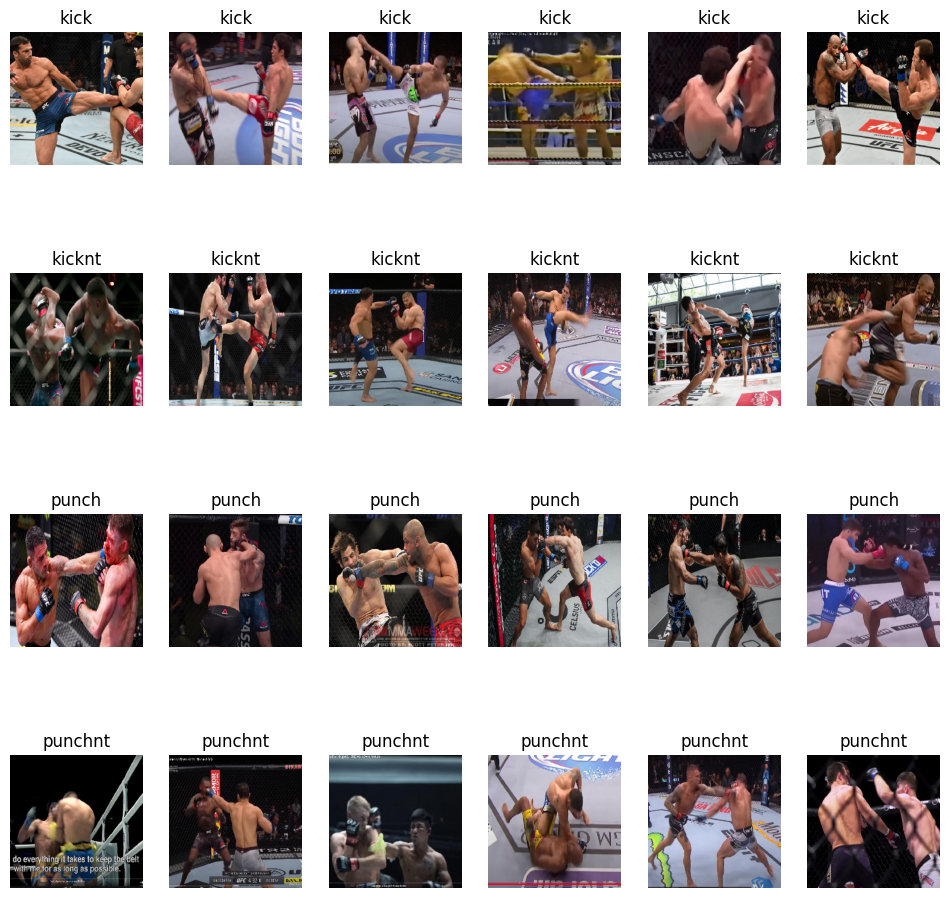

In [5]:
# Number of samples per class to display
num_samples_per_class = 6

# Function to display sample images from each class
def show_sample_images(data_dir, classes, num_samples_per_class):
    plt.figure(figsize=(12,12))

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        class_images = random.sample(os.listdir(class_dir), num_samples_per_class)

        for j, image_name in enumerate(class_images):
            image_path = os.path.join(class_dir, image_name)
            image = load_img(image_path, target_size=(weight_size, height_size))

            plt.subplot(len(classes), num_samples_per_class, i * num_samples_per_class + j + 1)
            plt.imshow(image)
            plt.title(class_name)
            plt.axis('off')

    plt.show()

# Call the function to show sample images from each class
show_sample_images(train_path, classes, num_samples_per_class)


In [6]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False

2023-07-31 22:26:49.123558: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-31 22:26:49.184694: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-31 22:26:49.184869: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
folders = glob('dataset/train/*')

In [9]:
len(folders)

4

vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
#x = layers.Rescaling(1./255)(vgg.output)
#x = base_model(x, training="false")
x = layers.Flatten()(vgg.output)
x = layers.Dropout(0.5)(x) # https://keras.io/api/layers/regularization_layers/dropout/
outputs = layers.Dense(4, activation="softmax")(x)
model = tf.keras.Model(inputs=vgg.input, outputs=outputs)
#model = tf.keras.Model(inputs=, outputs=outputs)

In [10]:
x = Flatten()(vgg.output)
#x = Dropout(0.5)(x)
#x = Dense(256, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)
vgg_model = Model(inputs=vgg.input, outputs=prediction)

In [11]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,           # Normalize pixel values to [0,1]
    rotation_range=90,           # Randomly rotate images by up to 20 degrees
    width_shift_range=0.4,       # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.4,      # Randomly shift images vertically by up to 20% of the height
    shear_range=0.5,             # Apply shear transformation
    zoom_range=0.2,              # Randomly zoom images by up to 20%
    horizontal_flip=True,        # Randomly flip images horizontally
    fill_mode='nearest'          # Use the nearest pixel to fill missing areas after augmentation
)

In [13]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
valid_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

Found 411 images belonging to 4 classes.


In [16]:
test_set = test_datagen.flow_from_directory(test_path,
                                             target_size=(224, 224),
                                             batch_size=batch_size,
                                             class_mode='categorical')

Found 61 images belonging to 4 classes.


In [17]:
valid_set = valid_datagen.flow_from_directory(valid_path,
                                             target_size=(224, 224),
                                             batch_size=batch_size,
                                             class_mode='categorical')

Found 130 images belonging to 4 classes.


### Displaying the augmentation of the images

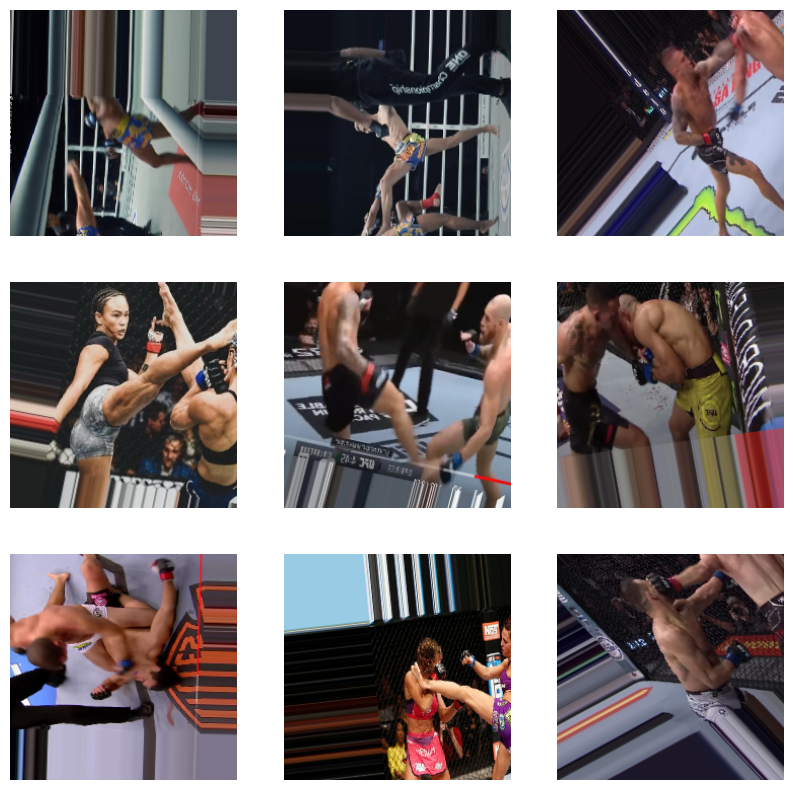

In [18]:
plt.figure(figsize=(10, 10))
images, _ = next(training_set)
for i, image in enumerate(images[: 9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis('off')

In [19]:
vgg_model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.00001),
              metrics=['accuracy'])

In [20]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [21]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_vgg_4_classes.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = vgg_model.fit(
    training_set,
    epochs=50,
    validation_data=valid_set,
    callbacks=callbacks)

Epoch 1/50


2023-07-31 22:26:51.235554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-31 22:26:52.980957: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-07-31 22:26:53.890238: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-31 22:26:55.229979: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-31 22:26:55.242710: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x5571e11c91e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-31 22:26:55.242728: I tensorflo

13/13 [==============================] - ETA: 0s - loss: 1.4233 - accuracy: 0.3358

2023-07-31 22:26:58.937481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


13/13 [==============================] - 9s 358ms/step - loss: 1.4233 - accuracy: 0.3358 - val_loss: 1.3943 - val_accuracy: 0.3385
Epoch 2/50
13/13 [==============================] - 3s 259ms/step - loss: 1.3780 - accuracy: 0.3236 - val_loss: 1.3974 - val_accuracy: 0.3308
Epoch 3/50
13/13 [==============================] - 3s 253ms/step - loss: 1.3977 - accuracy: 0.3114 - val_loss: 1.3983 - val_accuracy: 0.3231
Epoch 4/50
13/13 [==============================] - 3s 260ms/step - loss: 1.3998 - accuracy: 0.3090 - val_loss: 1.3979 - val_accuracy: 0.3462
Epoch 5/50
13/13 [==============================] - 3s 262ms/step - loss: 1.3995 - accuracy: 0.3260 - val_loss: 1.3984 - val_accuracy: 0.3462
Epoch 6/50
13/13 [==============================] - 4s 284ms/step - loss: 1.3905 - accuracy: 0.3139 - val_loss: 1.3926 - val_accuracy: 0.3462
Epoch 7/50
13/13 [==============================] - 4s 274ms/step - loss: 1.4137 - accuracy: 0.2871 - val_loss: 1.3890 - val_accuracy: 0.3615
Epoch 8/50
13/13 

In [22]:
test_model = keras.models.load_model(
    "./models/convnet_vgg_4_classes.keras")
test_loss, test_acc = test_model.evaluate(test_set)
print(f"Test accuracy: {test_acc:.3f}")

2023-07-31 22:30:02.862289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2/2 [==============================] - 2s 1s/step - loss: 1.3956 - accuracy: 0.3443
Test accuracy: 0.344


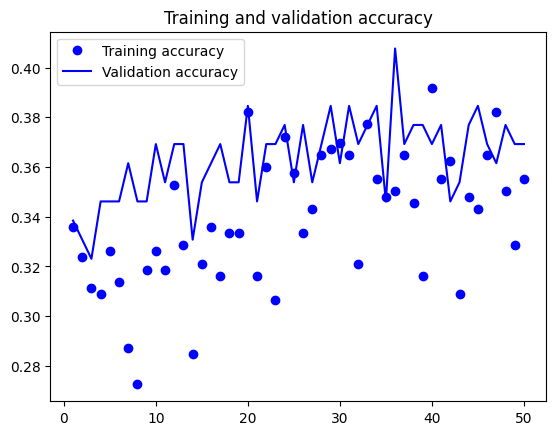

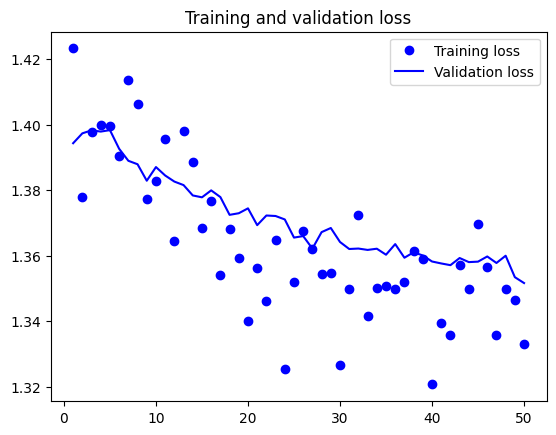

In [23]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Resnet50

In [24]:
from keras.applications.resnet_v2 import ResNet50V2

In [25]:
resnet = ResNet50V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [26]:
for layer in resnet.layers[:-1]:
    layer.trainable = False

In [27]:
resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [28]:
x = Flatten()(resnet.output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=resnet.input, outputs=prediction)

In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [30]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [31]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_resnet_4_classes.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    training_set,
    epochs=50,
    validation_data=valid_set,
    callbacks=callbacks)

Epoch 1/50


2023-07-31 22:30:06.838116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


13/13 [==============================] - ETA: 0s - loss: 11.4595 - accuracy: 0.2871

2023-07-31 22:30:12.567264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


13/13 [==============================] - 7s 365ms/step - loss: 11.4595 - accuracy: 0.2871 - val_loss: 7.9223 - val_accuracy: 0.3462
Epoch 2/50
13/13 [==============================] - 3s 265ms/step - loss: 10.1531 - accuracy: 0.3601 - val_loss: 10.4254 - val_accuracy: 0.3308
Epoch 3/50
13/13 [==============================] - 3s 257ms/step - loss: 10.0013 - accuracy: 0.3674 - val_loss: 9.2182 - val_accuracy: 0.3000
Epoch 4/50
13/13 [==============================] - 3s 253ms/step - loss: 9.9641 - accuracy: 0.3674 - val_loss: 11.7079 - val_accuracy: 0.2231
Epoch 5/50
13/13 [==============================] - 3s 258ms/step - loss: 8.8949 - accuracy: 0.3942 - val_loss: 13.4968 - val_accuracy: 0.3000
Epoch 6/50
13/13 [==============================] - 3s 255ms/step - loss: 10.0913 - accuracy: 0.3796 - val_loss: 13.5059 - val_accuracy: 0.2385
Epoch 7/50
13/13 [==============================] - 3s 247ms/step - loss: 9.5546 - accuracy: 0.3869 - val_loss: 8.7059 - val_accuracy: 0.3923
Epoch 8/5

In [32]:
test_model = keras.models.load_model(
    "./models/convnet_resnet_4_classes.keras")
test_loss, test_acc = test_model.evaluate(test_set)
print(f"Test accuracy: {test_acc:.3f}")

2023-07-31 22:32:57.575761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2/2 [==============================] - 1s 548ms/step - loss: 8.8857 - accuracy: 0.3115
Test accuracy: 0.311


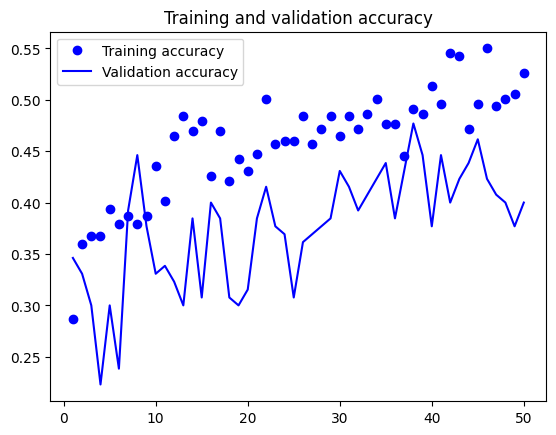

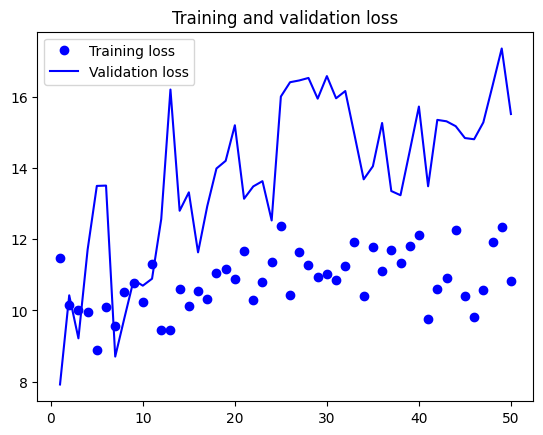

In [33]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### InceptionResNetV2

In [34]:
from keras.applications import InceptionResNetV2

In [35]:
inception = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

In [36]:
from keras.layers import GlobalAveragePooling2D

In [37]:

# Freeze the layers
for layer in inception.layers[:-3]:
    layer.trainable = False

In [38]:
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(len(folders), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)

In [39]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

                                                                                                  
 batch_normalization_14 (BatchN  (None, 35, 35, 32)  96          ['conv2d_14[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_17 (BatchN  (None, 35, 35, 64)  192         ['conv2d_17[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_12 (Activation)     (None, 35, 35, 32)   0           ['batch_normalization_12[0][0]'] 
                                                                                                  
 activation_14 (Activation)     (None, 35, 35, 32)   0           ['batch_normalization_14[0][0]'] 
          

In [40]:
# Define the optimizer and compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy'])

In [41]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_inceptionResnet_4_classes.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    training_set,
    steps_per_epoch=409//32,
    epochs=50,
    validation_data=valid_set,
    callbacks=callbacks,
    validation_steps=128//32)

Epoch 1/50


2023-07-31 22:33:03.528712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


12/12 [==============================] - ETA: 0s - loss: 1.4357 - accuracy: 0.2955

2023-07-31 22:33:16.641603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


12/12 [==============================] - 18s 804ms/step - loss: 1.4357 - accuracy: 0.2955 - val_loss: 1.4101 - val_accuracy: 0.2812
Epoch 2/50
12/12 [==============================] - 5s 383ms/step - loss: 1.4374 - accuracy: 0.2902 - val_loss: 1.3703 - val_accuracy: 0.3516
Epoch 3/50
12/12 [==============================] - 3s 275ms/step - loss: 1.3902 - accuracy: 0.3193 - val_loss: 1.3765 - val_accuracy: 0.3594
Epoch 4/50
12/12 [==============================] - 3s 283ms/step - loss: 1.4450 - accuracy: 0.3140 - val_loss: 1.3814 - val_accuracy: 0.3359
Epoch 5/50
12/12 [==============================] - 3s 268ms/step - loss: 1.4158 - accuracy: 0.3166 - val_loss: 1.3719 - val_accuracy: 0.3516
Epoch 6/50
12/12 [==============================] - 4s 362ms/step - loss: 1.4208 - accuracy: 0.2850 - val_loss: 1.3470 - val_accuracy: 0.3438
Epoch 7/50
12/12 [==============================] - 4s 368ms/step - loss: 1.4305 - accuracy: 0.3008 - val_loss: 1.3231 - val_accuracy: 0.3594
Epoch 8/50
12/12

In [42]:
test_model = keras.models.load_model(
    "./models/convnet_inceptionResnet_4_classes.keras")
test_loss, test_acc = test_model.evaluate(test_set)
print(f"Test accuracy: {test_acc:.3f}")

2023-07-31 22:36:44.943435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2/2 [==============================] - 3s 2s/step - loss: 1.3807 - accuracy: 0.3443
Test accuracy: 0.344


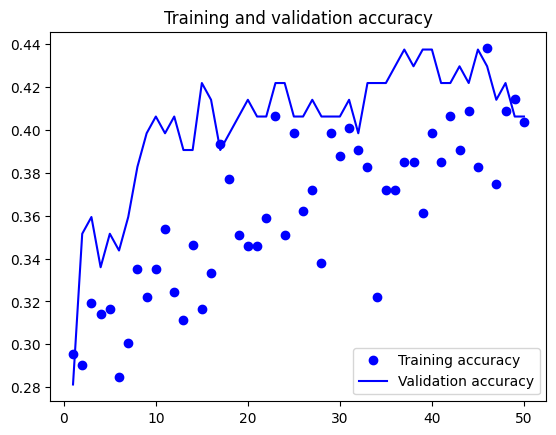

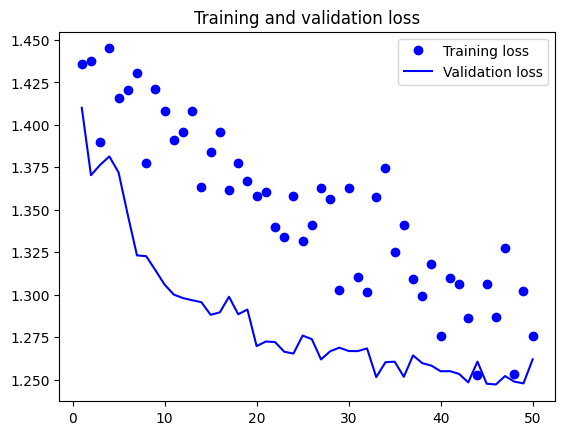

In [43]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## YoloV8

In [1]:
from ultralytics import YOLO

In [2]:
model = YOLO('yolov8n-cls.pt')  # load a pretrained model (recommended for training)

In [7]:

# Train the model
model.train(data='/home/jorgeluisg/Documents/001_George_brown/DL_2/project/dataset', epochs=20, imgsz=64)

New https://pypi.org/project/ultralytics/8.0.146 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.145 🚀 Python-3.9.16 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5947MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/home/jorgeluisg/Documents/001_George_brown/DL_2/project/dataset, epochs=20, patience=50, batch=16, imgsz=64, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, v

In [8]:
import PIL

ValueError: Could not save to JPEG for display

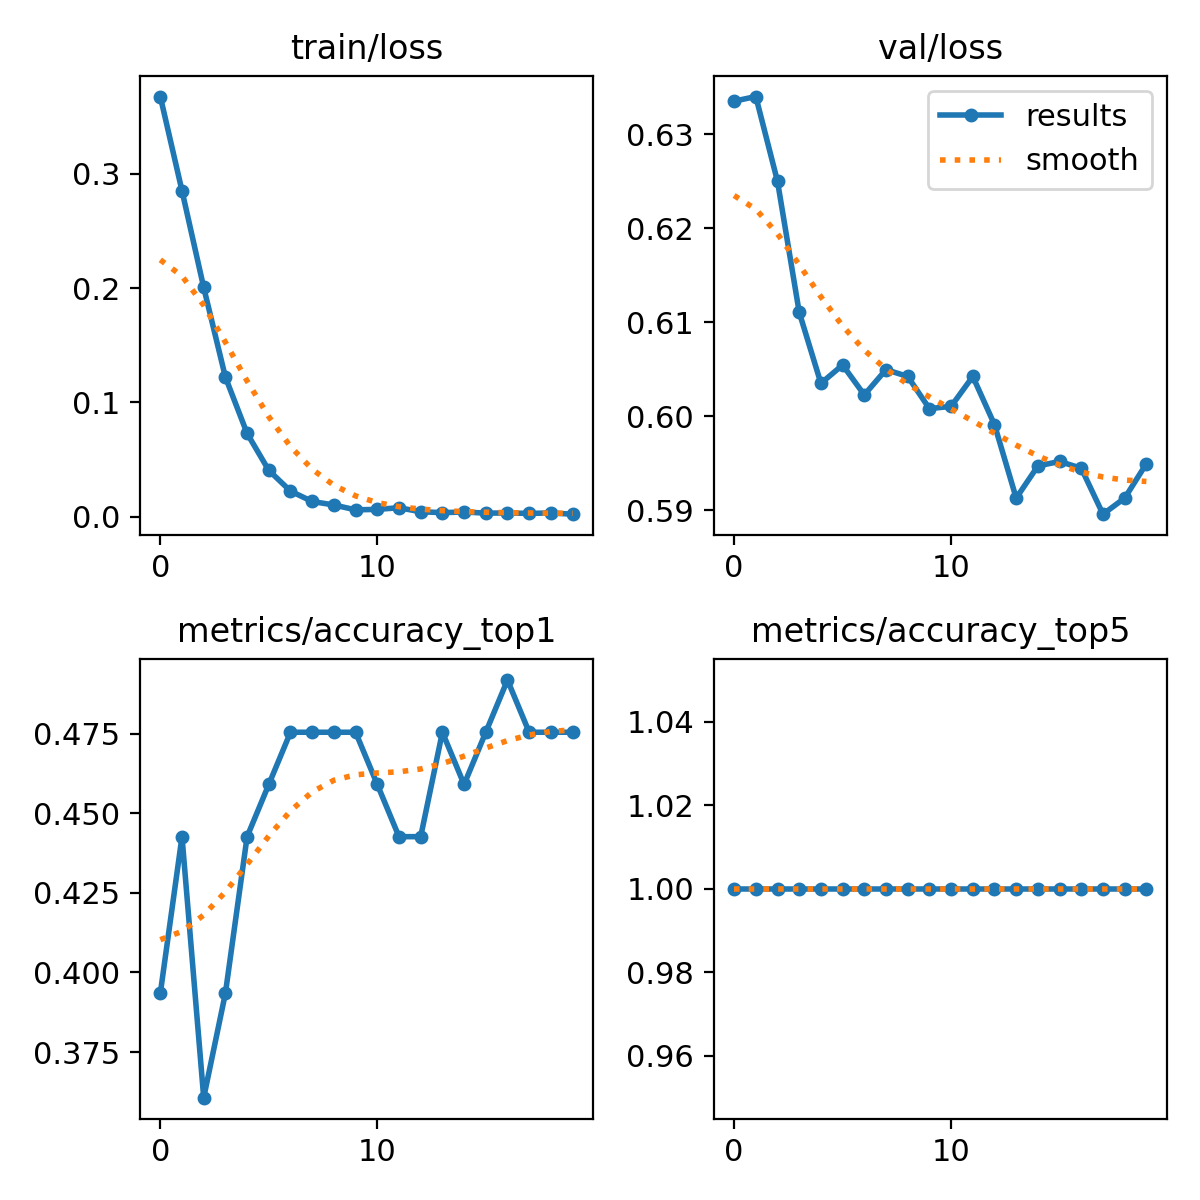

In [9]:
PIL.Image.open('/home/jorgeluisg/Documents/001_George_brown/DL_2/project/runs/classify/train9/results.png')

In [10]:
predict = YOLO('/home/jorgeluisg/Documents/001_George_brown/DL_2/project/runs/classify/train7/weights/best.pt')  # load a custom model

source = '/home/jorgeluisg/Documents/001_George_brown/DL_2/project/data/test/punch/Holm-vs-Aldana-1024x682_jpg.rf.09bae4f158e1f8cbb74a4047dbdafe5b.jpg'  # file/folder, 0 for webcam

In [11]:
# Predict with the model
results = predict(source)  # predict on an image


image 1/1 /home/jorgeluisg/Documents/001_George_brown/DL_2/project/data/test/punch/Holm-vs-Aldana-1024x682_jpg.rf.09bae4f158e1f8cbb74a4047dbdafe5b.jpg: 64x64 punch 0.73, kick 0.27, 2.0ms
Speed: 0.7ms preprocess, 2.0ms inference, 0.1ms postprocess per image at shape (1, 3, 64, 64)
